In [3]:
# Loading packages required

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

import pickle

In [4]:
# Loading data

training_set_features = pd.read_csv("training_set_features.csv", index_col = "respondent_id")
training_set_labels = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
test_set_features = pd.read_csv("test_set_features.csv", index_col = "respondent_id")

In [5]:
print("Shape of training data is {}".format(training_set_features.shape))
print("Shape of test data is {}".format(test_set_features.shape))

Shape of training data is (26707, 35)
Shape of test data is (26708, 35)


In [6]:
def data_prep_check(df):
        null_val = df.isnull().sum()
        null_val_percent = 100 * null_val / len(df)
        
        unique_vals_count = df.nunique(dropna=True)
        unique_vals = pd.Series({c: df[c].unique() for c in df})
        
        df_table = pd.concat([null_val, null_val_percent,unique_vals_count,unique_vals], axis=1)
        df_table = df_table.rename(columns = {0 : 'Null Values', 1 : '% of Total Values', 
                                              2 : 'Total Unique Values', 3 : 'Unique Values'})
        
        df_table['Data Type'] = df.dtypes
        df_table = df_table.sort_values('% of Total Values', ascending=False).round(1)
                
        print("The dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows.\n"      
              "There are " + str(df_table[df_table.iloc[:,1] != 0].shape[0]) + " columns that have missing values.")
        
        return df_table

In [7]:
# data_prep_check(training_set_features)
# data_prep_check(test_set_features)

### Converting binary columns from Float(numeric) to categorical for analysis
ML models treat categorical and numeric values differently even if they are binary. Hence, we explicitly define these columns to be categorical except 'household_adults' and 'household_children'

In [8]:
def convert_col_types(df):

    numeric_cols = ['household_children', 'household_adults']    # values of these columns are capped at 3
    convert_to_str = list(df.select_dtypes(include=['float64']).drop(numeric_cols, axis=1).columns)
    df[convert_to_str] = df[convert_to_str].astype('category')
    
    categorical_cols = list(df.select_dtypes(include=['object','category']).columns)
    opinion_cols = [col for col in df.columns if 'opinion' in col]

    return df, numeric_cols, categorical_cols, opinion_cols

# df, numeric_cols, categorical_cols, opinion_cols = convert_col_types(training_set_features)

## Check if missing data is MCAR, MAR or MNAR

### NA imputation - update based on MNAR analysis
For now, imputiting missing values with mode

In [9]:
def impute_na(df, col_type, strategy = 'most_frequent'):
    """Takes a dataframe and list of columns (default set to columns of 'float64' type), 
       and replaces NaN values with 'most_frequent'(default) of the column. 
       Other available strategies: 'mean', 'median'
       """
    
    num_imputer = SimpleImputer(strategy = strategy)
    df[col_type] = num_imputer.fit_transform(df[col_type])
    return df


def replace_unknown(df, col_type, fill_text = "Unknown"):
    
    """Takes a dataframe and list of columns (default set to columns of 'object' type), 
       and replaces NaN values with 'Unknown' or user-defined text to a create a new category"""
    
    text_imputer = SimpleImputer(strategy='constant', fill_value = fill_text)
    df[col_type] = text_imputer.fit_transform(df[col_type])
    return df

#### Multicolinearity check

In [10]:
# import seaborn as sns
# # sns.set_theme(style="white")

# data = training_set_features

# # Generate a large random dataset
# rs = np.random.RandomState(33)

# # Compute the correlation matrix
# corr = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask = mask, cmap = cmap, 
#             center = 0, vmax = 1, vmin = -1,
#             square = True, linewidths = .5, 
#             cbar_kws = {"shrink": .5})

In [11]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
#     corr_pairs = df.corr().abs().unstack()
    corr_pairs = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    corr_pairs = corr_pairs.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    return corr_pairs[0:n]

# a = training_set_features
# # a = a.drop(['employment_status', 'income_poverty'], axis = 1)
# get_top_abs_correlations(a, n = 5)



# To delete highly correlated features

def del_high_corr_features(df, threshold = 0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    cols_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(df[cols_to_drop], axis=1)
    
    return df, cols_to_drop, threshold

#### Dealing with Ordinal (opinion) variables

Dummies will be created for ordinal (opinion) variables to treat them as categorical. Otherwise the model will treat them as nominal which may lead unintended ordinality. 

An example of the scale used in the survey - 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high. 
Therefore, treating this as a nominal scale will cause issues such as average of 1 and 5 is 3 i.e. "Don't know"

In [36]:
def preprocessing_data(df): #, strategy = 'most_frequent', fill_text = "Unknown"):
    
    # delete highly correlated variables - before creating dummies
    df, cols_to_drop, threshold = del_high_corr_features(df, threshold = 0.95)
    print("Columns dropped due to multicoliearity at {} threshold:" .format(threshold), cols_to_drop)
    
    # convert column types and update dataframe
    df, numeric_cols, categorical_cols, opinion_cols = convert_col_types(df)
    
    # impute NAs for numerical variables
    df = impute_na(df, col_type = numeric_cols, strategy = 'most_frequent')    # check if strategy works at the function-level
    
    # replace NAs for categorical variables
    df = replace_unknown(df, col_type = categorical_cols, fill_text = "Unknown")
    
    # create dummies for categorical variables
    df = pd.get_dummies(df, columns = categorical_cols, dummy_na=False, drop_first=True,dtype=int)  # dummy_na=False because we are already imputing NAs as Unknown
    
    # cleaning column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' - ','_to_').str.replace(' ','_').str.replace('+','_and_above').str.replace('.0','').str.replace('-','_').str.replace(',','').str.replace('<','less_than').str.replace('>','more_than')
    
    return df

# data prep process check

In [37]:
# data = preprocessing_data(training_set_features)

In [38]:
# get_top_abs_correlations(data, n = 5)

In [39]:
# data_prep_check(data)

# Feature Selection

In [40]:
# import statsmodels.api as sm

# Xtrain = data
# ytrain = training_set_labels['h1n1_vaccine']

In [41]:
# ytrain

In [42]:
# log_reg = sm.Logit(ytrain, Xtrain).fit()

In [43]:
# print(log_reg.summary())

### Model building

In [44]:
train_df = preprocessing_data(training_set_features)
test_df = preprocessing_data(test_set_features)

Columns dropped due to multicoliearity at 0.95 threshold: []
Columns dropped due to multicoliearity at 0.95 threshold: []


In [45]:
train_labels = pd.read_csv("training_set_labels.csv", index_col="respondent_id")

In [46]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

import pickle

import warnings
warnings.filterwarnings("ignore")


RANDOM_SEED = 6  

In [69]:
X_train, X_val, y_train, y_val = train_test_split(train_df, train_labels, 
                                                  test_size = 0.2, 
                                                  shuffle = True,    
                                                 # stratify=train_labels,             # without stratifying the ratios are still maintained
                                                  random_state=RANDOM_SEED)

In [48]:
# Checking if data split is balanced

# print("len ytrain:", len(y_train))
# print("1s ytrain h1n1:", 100*(sum(y_train["h1n1_vaccine"])/len(y_train)))
# print("1s ytrain seas:", 100*(sum(y_train["seasonal_vaccine"])/len(y_train)))
# print()

# print("len yval:", len(y_val))
# print("1s yval h1n1:", 100*(sum(y_val["h1n1_vaccine"])/len(y_val)))
# print("1s yval seas:", 100*(sum(y_val["seasonal_vaccine"])/len(y_val)))

## Learn to use MLFlow

In [49]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

#### MultiOutputClassifier()
This strategy consists of fitting one classifier per target. In other words, you're treating the two outputs as separate classification tasks. This is a simple strategy for extending classifiers that do not natively support multi-target classification

In [50]:
def best_model_fit(X_train, y_train, X_val, y_val, clf, param):
    
    param = {f'estimator__{k}': v for k, v in param.items()}
    
    print("Parameters being tuned:", param)
    
    model = GridSearchCV(estimator = MultiOutputClassifier(clf), 
                         param_grid = param, 
                         cv=5, scoring="roc_auc", verbose = 1, n_jobs = -2)
    model.fit(X_train, y_train)

    print("Best cross validation score is:", model.best_score_)
    print(model.best_params_)    
    
    preds = model.predict_proba(X_val)
    
    print("validation_probas[0].shape", preds[0].shape)
    print("validation_probas[1].shape", preds[1].shape)

    y_preds = pd.DataFrame({ "h1n1_vaccine": preds[0][:, 1],
                             "seasonal_vaccine": preds[1][:, 1],
                            },
                            index = y_val.index
                           )
    print("y_preds.shape:", y_preds.shape)
    y_preds.head()
    
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    plot_roc(
        y_val['h1n1_vaccine'], 
        y_preds['h1n1_vaccine'], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    plot_roc(
        y_val['seasonal_vaccine'], 
        y_preds['seasonal_vaccine'], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    
    
    print("AUC-ROC Score:", roc_auc_score(y_val, y_preds))
    
    return model.best_estimator_

#### Using RandomSearchCV  - best model fit 2

In [51]:
def best_model_fit2(X_train, y_train, X_val, y_val, clf, param):
    
    param = {f'estimator__{k}': v for k, v in param.items()}
    
    print("Parameters being tuned:", param)
    
    model = RandomizedSearchCV(estimator = MultiOutputClassifier(clf), param_distributions = param, 
                         cv=5, scoring="roc_auc", verbose = 1, n_jobs = -2)
    model.fit(X_train, y_train)

    print("Best cross validation score is:", model.best_score_)
    print(model.best_params_)    
    
    preds = model.predict_proba(X_val)
    
    print("validation_probas[0].shape", preds[0].shape)
    print("validation_probas[1].shape", preds[1].shape)

    y_preds = pd.DataFrame({ "h1n1_vaccine": preds[0][:, 1],
                             "seasonal_vaccine": preds[1][:, 1],
                            },
                            index = y_val.index
                           )
    print("y_preds.shape:", y_preds.shape)
    y_preds.head()
    
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    plot_roc(
        y_val['h1n1_vaccine'], 
        y_preds['h1n1_vaccine'], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    plot_roc(
        y_val['seasonal_vaccine'], 
        y_preds['seasonal_vaccine'], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    
    
    print("AUC-ROC Score:", roc_auc_score(y_val, y_preds))
    
    return model.best_estimator_

In [28]:
# MultinomialNB_param = {
#     'alpha': [0, 1, 10, 20, 50, 100],   # tried [0,1, 1, 10]
#     'fit_prior': [True, False],
# }


# LogisticRegression_param = {
#     "C": [0.001, 0.003, 0.01, 0.03, 0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.4, 0.8, 1, 3, 10],     #[0.18, 0.2, 0.22, 0.3],        # tried [0.001, 0.003, 0.01, 0.03, 0.1, 0.15, 0.2, 0.22, 0.25 0.3, 0.4, 0.8 1, 3, 10] 
#     "max_iter": [100, 110, 125, 140, 150, 175, 200],   # tried [25, 50, 100, 125, 150, 175, 200,250]
#     "penalty": ["l2"],                  # tried ["l1", "l2"]
# }


# {'estimator__C': 0.22, 'estimator__max_iter': 140, 'estimator__penalty': 'l2'}
# {'estimator__C': 0.25, 'estimator__max_iter': 125, 'estimator__penalty': 'l2'}

# DecisionTreeClassifier_param = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": [40, 80, 100],    
#     "max_features": ["None","auto",'sqrt', "log2"],      
#     "min_samples_leaf": [3,5],
#     "min_samples_split": [2,3]
# }

# {'estimator__criterion': 'gini', 'estimator__max_depth': 80, 'estimator__max_features': 'sqrt', 
#  'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 3}

# #-------------------------------------------------------------------------------------------

# RandomForestClassifier_param = {
#     "bootstrap": [True],   
#     "n_estimators": [100, 150], #[300, 400],      # tried [100, 200, 250, 300]
#     "max_depth": [10,30],     # tried already with [10, 30, 40, 50, 60, 80]
#     "max_features": ["auto"], #["None","auto",'sqrt', "log2"],      # tried ["auto",'sqrt']
#     "min_samples_leaf": [3],       # tried [2, 3, 4]        # 3 seems to be the best
#     "min_samples_split": [3],    # started with [2, 3, 5]   # 3 seems to be the best
# }


# {'estimator__bootstrap': True, 'estimator__max_depth': 10, 'estimator__max_features': 'auto', 
#  'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 100}

# #---------------------------------------------------------------------------------------------

# XGBClassifier_param = {
#     "n_estimators": [50, 100, 200, 300],   # started with [50, 100, 200, 300]
#     "objective": ["binary:logistic"],
#     "min_child_weight": [1],
#     "gamma": [0.5, 0.8, 1.0],   # started with [0.5, 0.8, 1.0]
#     "subsample": [0.6, 0.8, 1.0],   # started with [0.6, 0.8, 1.0]
#     "colsample_bytree": [0.8, 1.0],   # started with [0.8, 1.0]
#     "max_depth": [1, 3, 5],   # started with [1, 3, 5]
# }

#### 1. Gaussian Naive Bayes model - check if this is correct usage of the model
Hyperparameters to tune:
 

In [31]:
# GaussianNB_param = {
#      'alpha': [0, 1, 10, 20, 50, 100],   # tried [0,1, 1, 10]
#      'fit_prior': [True, False]
# }

# # {'estimator__alpha': 50, 'estimator__fit_prior': True}

In [32]:
# gauss_nb_model = best_model_fit(X_train, y_train, X_val, y_val, GaussianNB(), GaussianNB_param)

In [34]:
# gauss_nb_model.fit(train_df, train_labels)    # fitting model on all training data

# # save the model to disk
# filename = 'full_gauss_nb_model.sav'
# pickle.dump(gauss_nb_model, open(filename, 'wb'))

# # load the model from disk
# full_gauss_nb_model = pickle.load(open(filename, 'rb'))

#### 2. Logistic Regression model
Hyperparameters to tune:
 

In [116]:
    LogisticRegression_param = {
        "C":[0.23, 0.25, 0.28],  # [0.001, 0.003, 0.01, 0.03, 0.1, 0.15, 0.2, 0.22, 0.25, 0.3, 0.4, 0.8, 1, 3, 10]
        "max_iter": [115, 120, 125, 130, 135],   # [100, 110, 125, 140, 150, 175, 200]
        "penalty": ["l2"],                       # ["l1", "l2"]
        "random_state":[RANDOM_SEED]
    }

# Best Estimators: {'estimator__C': 0.25, 'estimator__max_iter': 125, 'estimator__penalty': 'l2'}
# AUC-ROC Score: 0.8696665131636843

Parameters being tuned: {'estimator__C': [0.23, 0.25, 0.28], 'estimator__max_iter': [115, 120, 125, 130, 135], 'estimator__penalty': ['l2'], 'estimator__random_state': [6]}
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   35.5s finished


Best cross validation score is: 0.8590759735066902
{'estimator__C': 0.25, 'estimator__max_iter': 135, 'estimator__penalty': 'l2', 'estimator__random_state': 6}
validation_probas[0].shape (5342, 2)
validation_probas[1].shape (5342, 2)
y_preds.shape: (5342, 2)
AUC-ROC Score: 0.8696665131636843


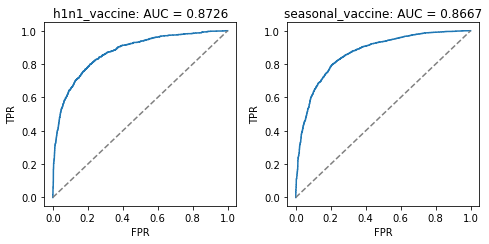

In [117]:
logit_model = best_model_fit(X_train, y_train, X_val, y_val, LogisticRegression(), LogisticRegression_param)

In [118]:
# best_logit_model = logit_model.best_estimator_

In [119]:
logit_model.fit(train_df, train_labels)    # fitting model on all training data

# save the model to disk
filename = 'full_logit_model.sav'
pickle.dump(logit_model, open(filename, 'wb'))

# load the model from disk
full_logit_model = pickle.load(open(filename, 'rb'))

In [ ]:
# logit_model.estimators_[0].coef_

In [ ]:
from matplotlib import pyplot
# model.fit(X, y)
# get importance
importance = logit_model.estimators_[0].coef_[0]
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


#### 3. Decision Trees model
Hyperparameters to tune:
 - criterion:
 - max_depth:
 - max_features: 
     - if "None" (default), then uses all features
     - if "auto” then uses sqrt(n_features)
     - decimal values indicate the proportion of features to use
     - integer values indicate the number of features to use
 - min_samples_split: Higher value will tend to make the model to underfit
 - min_samples_leaf: Higher value will tend to make the model to underfit

In [ ]:
DecisionTreeClassifier_param = {
    "criterion": ["gini", "entropy"],
    "max_depth": [8],                  # [3, 5, 8, 9, 10, 30, 50, 70, 100]
    "max_features": [0.7],        # [0.5, 0.6, 0.7, 0.8,, 0.9,'sqrt', "log2"]
    "min_samples_leaf": [10],       # [3,5,6,7,8,10,12,15]  #8 was next best   
    "min_samples_split": [3],          # [2,3,4]
    "random_state":[RANDOM_SEED]
}

# Best estimators: {'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__max_features': 0.7, 
#                   'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 3, 'estimator__random_state': 6}

In [ ]:
dt_model = best_model_fit(X_train, y_train, X_val, y_val, DecisionTreeClassifier(), DecisionTreeClassifier_param)

In [ ]:
dt_model.fit(train_df, train_labels)    # fitting model on all training data

# save the model to disk
filename = 'full_dt_model.sav'
pickle.dump(dt_model, open(filename, 'wb'))

# load the model from disk
full_dt_model = pickle.load(open(filename, 'rb'))

#### 4. Random Forest model

In [ ]:
RandomForestClassifier_param = {
    "bootstrap": [True],
    "criterion": ['gini', 'entropy'],
    "n_estimators": [175],               # tried [100, 200, 250, 300, 350, 400, 450, 500, 550]
    "max_depth": [21],           # [10, 30, 40, 50, 55, 60, 80]
    "max_features": [0.5, 'sqrt'],            #["None","auto",'sqrt', "log2"]
    "min_samples_leaf": [8],             # tried [2, 3, 4, 10]        # 3 seems to be the best
    "min_samples_split": [4],            # started with [2, 3, 5]   # 3 seems to be the best
    "random_state":[RANDOM_SEED],
}

# {'estimator__n_estimators': 400, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 3,
#  'estimator__max_features': 'sqrt', 'estimator__max_depth': 50, 'estimator__bootstrap': True}
# AUC-ROC Score: 0.8630901058762661

# {'estimator__n_estimators': 450, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 3, 
#  'estimator__max_features': 'sqrt', 'estimator__max_depth': 50, 'estimator__bootstrap': True}
# AUC-ROC Score: 0.8630802494382964

# {'estimator__n_estimators': 500, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 3, 
#  'estimator__max_features': 'sqrt', 'estimator__max_depth': 50, 'estimator__bootstrap': True}
# AUC-ROC Score: 0.8631824976400506


# BEST TILL NOW
# {'estimator__n_estimators': 550, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 3, 
#  'estimator__max_features': 'sqrt', 'estimator__max_depth': 55, 'estimator__bootstrap': True}
# AUC-ROC Score: 0.8633029360653007

In [ ]:
%%time

rf_model = best_model_fit(X_train, y_train, X_val, y_val, 
                          RandomForestClassifier(random_state = RANDOM_SEED,
                                                 bootstrap = True,
                                                 n_jobs = -2, warm_start = True), 
                          RandomForestClassifier_param)

In [ ]:
%%time

rf_model2 = best_model_fit2(X_train, y_train, X_val, y_val,
                            RandomForestClassifier(random_state = RANDOM_SEED,
                                                   bootstrap = True,
                                                   n_jobs = -2, warm_start = True),
                            RandomForestClassifier_param)

In [ ]:
rf_model2.fit(train_df, train_labels)    # fitting model on all training data

# save the model to disk
filename = 'full_rf_model2.sav'
pickle.dump(rf_model2, open(filename, 'wb'))

# load the model from disk
full_rf_model2 = pickle.load(open(filename, 'rb'))

#### 5. Extra Trees Classifier

In [ ]:
ExtraTreesClassifier_param = {
    "n_estimators": [175],               # [25, 50, 75, 100, 125, 150, 175, 200, 225]
    "criterion": ['gini', 'entropy'],
    "max_depth": [21],                   # [3, 5, 8, 12, 15, 20]
    "min_samples_split": [4], #3               # [2, 3, 5, 6, 8] 
    "min_samples_leaf": [8],            # [5, 10, 15, 20, 25, 30]
    "max_features": [0.5],   #[0.4, 0.5, 0.6, 0.8, 'sqrt', 'log2']
}

# {'estimator__n_estimators': 75, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 15, 
#  'estimator__max_features': 0.5, 'estimator__max_depth': 12, 'estimator__criterion': 'gini'}
# AUC-ROC Score: 0.8607155521518826

# {'estimator__n_estimators': 200, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 8, 
#  'estimator__max_features': 0.3, 'estimator__max_depth': 12, 'estimator__criterion': 'gini'}
# AUC-ROC Score: 0.8615500364728843
    
# {'estimator__n_estimators': 150, 'estimator__min_samples_split': 4, 'estimator__min_samples_leaf': 8, 
#  'estimator__max_features': 0.5, 'estimator__max_depth': 20, 'estimator__criterion': 'entropy'}
# AUC-ROC Score: 0.862731678392982    

# 0.8628674920491015  with max depth 22
# 0.8632317792808505  with max depth 19
# 0.8634924915439375  with max depth 21 and n_estimators 150
# 0.8635632393978094  with max depth 21 and n_estimators 200
# 0.8636395967833451  with max depth 21 and n_estimators 175       # Best - submission 13
# 0.8636318212786569  with max depth 21 and n_estimators 165

In [ ]:
%%time

extraTrees_model2 = best_model_fit2(X_train, y_train, X_val, y_val, 
                                  ExtraTreesClassifier(random_state = RANDOM_SEED,
                                                       bootstrap = True,
                                                       n_jobs = -2, warm_start = True), 
                                  ExtraTreesClassifier_param)

In [ ]:
# %%time

# extraTrees_model = best_model_fit(X_train, y_train, X_val, y_val, 
#                                   ExtraTreesClassifier(random_state = RANDOM_SEED,
#                                                        bootstrap = True,
#                                                        n_jobs = -2, warm_start = True), 
#                                   ExtraTreesClassifier_param)


In [ ]:
extraTrees_model2.fit(train_df, train_labels)    # fitting model on all training data

# save the model to disk
filename = 'full_etc_model2.sav'
pickle.dump(extraTrees_model2, open(filename, 'wb'))

# load the model from disk
full_etc_model2 = pickle.load(open(filename, 'rb'))

#### 6. Gradient Boosting

Gradient boosting is a generalization of AdaBoosting. It is an ensemble created from decision trees added sequentially to the model.

More details on https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

In [ ]:
GBMClassifier_param = {
    
}

In [ ]:
%%time

GBM_model = best_model_fit(X_train, y_train, X_val, y_val, 
                                  GradientBoostingClassifier(), 
                                  GBMClassifier_param)


#### 7. Histogram-based Gradient Boosting - model still under experimentation

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
HistGBMClassifier_param = {
    "learning_rate": [0.1],   # default = 0.1 #Use 1 for no shrinkage. # tried [0.01, 0.03, 0.08, 0.1, 0.3, 0.5, 1]
    "max_iter": [100],    # default = 100
    "max_leaf_nodes": [10],  # default = 31            # tried [10, 20, 31]  
    "max_depth": [10],                                 # tried [2, 10, 20]
    "min_samples_leaf": [20],    # default = 20        # tried [5, 20, 40]
    
    "max_bins":[255],   # default = 255 (max value)   # tried [100,255]
    "l2_regularization": [0.2]  # default = 0         # tried [0.2, 0.5, 0.8]
 }

# {'estimator__l2_regularization': 0.2, 'estimator__learning_rate': 0.1, 'estimator__max_bins': 100, 
#  'estimator__max_depth': 10, 'estimator__max_iter': 100, 'estimator__max_leaf_nodes': 10, 
#  'estimator__min_samples_leaf': 20}
# AUC-ROC Score: 0.8652064722535789

In [ ]:
# %%time

# HistGBM_model = best_model_fit(X_train, y_train, X_val, y_val, 
#                                   HistGradientBoostingClassifier(loss = 'binary_crossentropy', 
#                                                                  warm_start = True, 
# #                                                                  early_stopping = True,
# #                                                                  scoring = 'loss',
#                                                                  n_iter_no_change = 10,  # default = 10
#                                                                  random_state = RANDOM_SEED 
#                                                                 ), 
#                                   HistGBMClassifier_param)


In [ ]:
%%time

HistGBM_model2 = best_model_fit2(X_train, y_train, X_val, y_val, 
                                  HistGradientBoostingClassifier(loss = 'binary_crossentropy', 
                                                                 warm_start = True, 
#                                                                  early_stopping = True,
#                                                                  scoring = 'loss',
                                                                 n_iter_no_change = 10,  # default = 10
                                                                 random_state = RANDOM_SEED 
                                                                ), 
                                  HistGBMClassifier_param)


In [ ]:
HistGBM_model2.fit(train_df, train_labels)    # fitting model on all training data

# save the model to disk
filename = 'full_HistGBM_model2.sav'
pickle.dump(HistGBM_model2, open(filename, 'wb'))

# load the model from disk
full_HistGBM_model2 = pickle.load(open(filename, 'rb'))

#### 8. XGB - Requies clean column names

In [53]:
from xgboost import XGBClassifier

In [67]:
XGBClassifier_param = {

}

In [72]:
%%time
# X_train_arr = np.array(X_train)
# y_train_arr = np.array(y_train)
# X_val_arr = np.array(X_val)
# y_val_arr = np.array(y_val)

xgb_model2 = best_model_fit2(X_train.values, y_train.values, X_val.values, y_val.values,
                             XGBClassifier(), 
                             XGBClassifier_param)

Parameters being tuned: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  1.7min finished


Best cross validation score is: 0.8491613144344659
{}
validation_probas[0].shape (5342, 2)
validation_probas[1].shape (5342, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'index'

#### 9. LightGBM

Light GBM ***grows tree vertically*** while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

Light GBM is sensitive to overfitting and can easily overfit small data

Parameter tuning guide: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

When the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

In [35]:
from lightgbm import LGBMClassifier

In [36]:
LGBMClassifier_param = {
    "learning_rate": [0.2, 0.3],          # [0.01, 0.03, 0.1, 0.3, 0.4, 0.5, 1]  
    "num_leaves": [10],        # default: 31   # [5, 8, 10, 12, 15, 31, 70]
    "max_depth":[7, 8],                        # [4, 7, 9, 10, 15]
#     "min_data_in_leaf": [],
    "feature_fraction": [0.4, 0.6],   #[0.4, 0.8]
#     "bagging_fraction": [],
    "lambda": [0.3, 0.4],        # [0.2, 0.5, 0.8,0.5, 0.6]
    "boosting": ['gbdt', 'dart'],    # ['gbdt', 'rf', 'dart', 'goss']
    "num_boost_round": [100, 120],   # typically >100   # [80, 100, 120, 140]
    
#     "min_gain_to_split": [],
#     "max_cat_group": [],
    
}

# AUC-ROC Score: 0.8715956486995493  default model

# {'estimator__num_leaves': 10, 'estimator__num_boost_round': 100, 'estimator__max_depth': 8, 
#  'estimator__learning_rate': 0.2, 'estimator__lambda': 0.3, 'estimator__feature_fraction': 0.4, 
#  'estimator__boosting': 'gbdt'}
# AUC-ROC Score: 0.871739502253682

# With GridSearchCV
# {'estimator__boosting': 'dart', 'estimator__feature_fraction': 0.6, 'estimator__lambda': 0.3, 
#  'estimator__learning_rate': 0.3, 'estimator__max_depth': 7, 'estimator__num_boost_round': 120, 
#  'estimator__num_leaves': 10}
# AUC-ROC Score: 0.8701297025055219


# With RandomizedSearch CV
# {'estimator__num_leaves': 10, 'estimator__num_boost_round': 100, 'estimator__max_depth': 7, 
#  'estimator__learning_rate': 0.2, 'estimator__lambda': 0.4, 'estimator__feature_fraction': 0.4, 
#  'estimator__boosting': 'gbdt'}
# AUC-ROC Score: 0.872095747195412

Parameters being tuned: {'estimator__learning_rate': [0.2, 0.3], 'estimator__num_leaves': [10], 'estimator__max_depth': [7, 8], 'estimator__feature_fraction': [0.4, 0.6], 'estimator__lambda': [0.3, 0.4], 'estimator__boosting': ['gbdt', 'dart'], 'estimator__num_boost_round': [100, 120]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:   14.0s finished


[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.4. Current value: lambda_l2=0.4
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] num_iterations is set=120, num_boost_round=120 will be ignored. Current value: num_iterations=120
Best cross validation score is: 0.8616851435594383
{'estimator__num_leaves': 10, 'estimator__num_boost_round': 120, 'estimator__max_depth': 8, 'estimator__learning_rate': 0.3, 'estimator__lambda': 0.4, 'estimator__feature_fraction': 0.6, 'estimator__boosting': 'dart'}
validation_probas[0].shape (5342, 2)
validation_probas[1].shape (5342, 2)
y_preds.shape: (5342, 2)
AUC-ROC Score: 0.8716025358415826
Wall time: 15.8 s


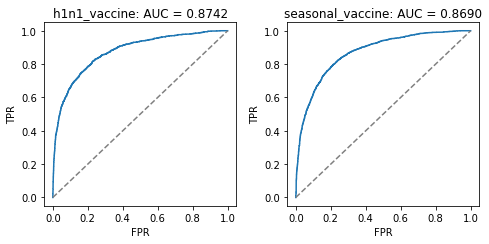

In [37]:
%%time

lgbm_model2 = best_model_fit2(X_train, y_train, X_val, y_val,
                             LGBMClassifier(
                                 application = 'binary',
                                 metric = 'binary_logloss',
                                 save_binary = True             # LightGBM will save the dataset (including validation data) to a binary file. This speed ups the data loading for the next time
#                                  early_stopping_round = 
                             
                             ), 
                             LGBMClassifier_param)


In [38]:
# %%time

# lgbm_model = best_model_fit(X_train, y_train, X_val, y_val,
#                              LGBMClassifier(
#                                  application = 'binary',
#                                  metric = 'binary_logloss',
#                                  save_binary = True             # LightGBM will save the dataset (including validation data) to a binary file. This speed ups the data loading for the next time
# #                                  early_stopping_round = 
                             
#                              ), 
#                              LGBMClassifier_param)


In [204]:
# lgbm_model2.fit(train_df, train_labels)    # fitting model on all training data

# # save the model to disk
filename = 'full_lgbm_model2.sav'
pickle.dump(lgbm_model2, open(filename, 'wb'))

# load the model from disk
full_lgbm_model2 = pickle.load(open(filename, 'rb'))

In [29]:
from catboost import CatBoostClassifier

In [30]:
CatBoostClassifier_param = {}

Parameters being tuned: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  3.4min finished


Learning rate set to 0.038082
0:	learn: 0.6643682	total: 130ms	remaining: 2m 9s
1:	learn: 0.6389583	total: 152ms	remaining: 1m 15s
2:	learn: 0.6154337	total: 192ms	remaining: 1m 3s
3:	learn: 0.5928011	total: 209ms	remaining: 52.1s
4:	learn: 0.5746826	total: 226ms	remaining: 45s
5:	learn: 0.5575301	total: 248ms	remaining: 41.1s
6:	learn: 0.5404519	total: 267ms	remaining: 37.8s
7:	learn: 0.5258790	total: 283ms	remaining: 35.1s
8:	learn: 0.5125577	total: 300ms	remaining: 33s
9:	learn: 0.5002830	total: 320ms	remaining: 31.7s
10:	learn: 0.4897115	total: 336ms	remaining: 30.3s
11:	learn: 0.4790172	total: 371ms	remaining: 30.6s
12:	learn: 0.4700525	total: 387ms	remaining: 29.4s
13:	learn: 0.4614502	total: 408ms	remaining: 28.7s
14:	learn: 0.4537361	total: 434ms	remaining: 28.5s
15:	learn: 0.4465263	total: 459ms	remaining: 28.2s
16:	learn: 0.4403204	total: 483ms	remaining: 27.9s
17:	learn: 0.4347248	total: 499ms	remaining: 27.2s
18:	learn: 0.4297620	total: 521ms	remaining: 26.9s
19:	learn: 0.4

165:	learn: 0.3401003	total: 3.75s	remaining: 18.9s
166:	learn: 0.3399504	total: 3.77s	remaining: 18.8s
167:	learn: 0.3397603	total: 3.79s	remaining: 18.8s
168:	learn: 0.3395906	total: 3.81s	remaining: 18.7s
169:	learn: 0.3393535	total: 3.83s	remaining: 18.7s
170:	learn: 0.3391707	total: 3.86s	remaining: 18.7s
171:	learn: 0.3390558	total: 3.88s	remaining: 18.7s
172:	learn: 0.3388781	total: 3.91s	remaining: 18.7s
173:	learn: 0.3386658	total: 3.93s	remaining: 18.6s
174:	learn: 0.3384715	total: 3.96s	remaining: 18.6s
175:	learn: 0.3383492	total: 3.98s	remaining: 18.6s
176:	learn: 0.3382272	total: 3.99s	remaining: 18.6s
177:	learn: 0.3380607	total: 4.01s	remaining: 18.5s
178:	learn: 0.3379047	total: 4.03s	remaining: 18.5s
179:	learn: 0.3377957	total: 4.05s	remaining: 18.5s
180:	learn: 0.3376716	total: 4.07s	remaining: 18.4s
181:	learn: 0.3375509	total: 4.09s	remaining: 18.4s
182:	learn: 0.3374278	total: 4.11s	remaining: 18.3s
183:	learn: 0.3373108	total: 4.13s	remaining: 18.3s
184:	learn: 

324:	learn: 0.3186077	total: 7.15s	remaining: 14.9s
325:	learn: 0.3184956	total: 7.17s	remaining: 14.8s
326:	learn: 0.3183658	total: 7.19s	remaining: 14.8s
327:	learn: 0.3181985	total: 7.22s	remaining: 14.8s
328:	learn: 0.3181281	total: 7.24s	remaining: 14.8s
329:	learn: 0.3180249	total: 7.26s	remaining: 14.7s
330:	learn: 0.3178626	total: 7.28s	remaining: 14.7s
331:	learn: 0.3177506	total: 7.29s	remaining: 14.7s
332:	learn: 0.3176746	total: 7.32s	remaining: 14.7s
333:	learn: 0.3175270	total: 7.33s	remaining: 14.6s
334:	learn: 0.3173964	total: 7.36s	remaining: 14.6s
335:	learn: 0.3172666	total: 7.39s	remaining: 14.6s
336:	learn: 0.3171051	total: 7.4s	remaining: 14.6s
337:	learn: 0.3170081	total: 7.43s	remaining: 14.5s
338:	learn: 0.3168496	total: 7.44s	remaining: 14.5s
339:	learn: 0.3167337	total: 7.46s	remaining: 14.5s
340:	learn: 0.3165793	total: 7.48s	remaining: 14.4s
341:	learn: 0.3164812	total: 7.5s	remaining: 14.4s
342:	learn: 0.3163594	total: 7.51s	remaining: 14.4s
343:	learn: 0.

491:	learn: 0.3002014	total: 10.5s	remaining: 10.8s
492:	learn: 0.3000742	total: 10.5s	remaining: 10.8s
493:	learn: 0.2999897	total: 10.6s	remaining: 10.8s
494:	learn: 0.2998850	total: 10.6s	remaining: 10.8s
495:	learn: 0.2997818	total: 10.6s	remaining: 10.8s
496:	learn: 0.2997100	total: 10.6s	remaining: 10.7s
497:	learn: 0.2996212	total: 10.6s	remaining: 10.7s
498:	learn: 0.2995270	total: 10.7s	remaining: 10.7s
499:	learn: 0.2993879	total: 10.7s	remaining: 10.7s
500:	learn: 0.2992882	total: 10.7s	remaining: 10.7s
501:	learn: 0.2991964	total: 10.7s	remaining: 10.6s
502:	learn: 0.2991099	total: 10.7s	remaining: 10.6s
503:	learn: 0.2990028	total: 10.8s	remaining: 10.6s
504:	learn: 0.2989183	total: 10.8s	remaining: 10.6s
505:	learn: 0.2988209	total: 10.8s	remaining: 10.5s
506:	learn: 0.2987599	total: 10.8s	remaining: 10.5s
507:	learn: 0.2986930	total: 10.8s	remaining: 10.5s
508:	learn: 0.2986141	total: 10.8s	remaining: 10.4s
509:	learn: 0.2985348	total: 10.9s	remaining: 10.4s
510:	learn: 

654:	learn: 0.2854206	total: 14s	remaining: 7.39s
655:	learn: 0.2852908	total: 14.1s	remaining: 7.37s
656:	learn: 0.2851915	total: 14.1s	remaining: 7.35s
657:	learn: 0.2851177	total: 14.1s	remaining: 7.33s
658:	learn: 0.2850710	total: 14.1s	remaining: 7.31s
659:	learn: 0.2849955	total: 14.1s	remaining: 7.29s
660:	learn: 0.2849266	total: 14.2s	remaining: 7.27s
661:	learn: 0.2848528	total: 14.2s	remaining: 7.25s
662:	learn: 0.2847641	total: 14.2s	remaining: 7.23s
663:	learn: 0.2846801	total: 14.3s	remaining: 7.21s
664:	learn: 0.2846275	total: 14.3s	remaining: 7.19s
665:	learn: 0.2845565	total: 14.3s	remaining: 7.17s
666:	learn: 0.2844735	total: 14.3s	remaining: 7.15s
667:	learn: 0.2843763	total: 14.3s	remaining: 7.13s
668:	learn: 0.2842736	total: 14.4s	remaining: 7.11s
669:	learn: 0.2842100	total: 14.4s	remaining: 7.09s
670:	learn: 0.2841579	total: 14.4s	remaining: 7.07s
671:	learn: 0.2840796	total: 14.4s	remaining: 7.04s
672:	learn: 0.2839714	total: 14.5s	remaining: 7.02s
673:	learn: 0.

815:	learn: 0.2727095	total: 17.5s	remaining: 3.94s
816:	learn: 0.2726192	total: 17.5s	remaining: 3.92s
817:	learn: 0.2725412	total: 17.5s	remaining: 3.9s
818:	learn: 0.2724225	total: 17.6s	remaining: 3.88s
819:	learn: 0.2722852	total: 17.6s	remaining: 3.86s
820:	learn: 0.2722058	total: 17.6s	remaining: 3.84s
821:	learn: 0.2721337	total: 17.6s	remaining: 3.82s
822:	learn: 0.2721172	total: 17.6s	remaining: 3.79s
823:	learn: 0.2720175	total: 17.7s	remaining: 3.77s
824:	learn: 0.2719448	total: 17.7s	remaining: 3.75s
825:	learn: 0.2718834	total: 17.7s	remaining: 3.73s
826:	learn: 0.2717976	total: 17.7s	remaining: 3.71s
827:	learn: 0.2716966	total: 17.7s	remaining: 3.69s
828:	learn: 0.2716279	total: 17.8s	remaining: 3.66s
829:	learn: 0.2715754	total: 17.8s	remaining: 3.65s
830:	learn: 0.2714963	total: 17.8s	remaining: 3.62s
831:	learn: 0.2714496	total: 17.8s	remaining: 3.6s
832:	learn: 0.2713846	total: 17.9s	remaining: 3.58s
833:	learn: 0.2712820	total: 17.9s	remaining: 3.56s
834:	learn: 0.

978:	learn: 0.2609467	total: 21.1s	remaining: 453ms
979:	learn: 0.2608826	total: 21.1s	remaining: 431ms
980:	learn: 0.2607946	total: 21.1s	remaining: 409ms
981:	learn: 0.2607489	total: 21.2s	remaining: 388ms
982:	learn: 0.2607158	total: 21.2s	remaining: 366ms
983:	learn: 0.2606633	total: 21.2s	remaining: 345ms
984:	learn: 0.2606202	total: 21.2s	remaining: 323ms
985:	learn: 0.2605303	total: 21.2s	remaining: 302ms
986:	learn: 0.2604580	total: 21.3s	remaining: 280ms
987:	learn: 0.2604148	total: 21.3s	remaining: 259ms
988:	learn: 0.2603743	total: 21.3s	remaining: 237ms
989:	learn: 0.2603337	total: 21.3s	remaining: 215ms
990:	learn: 0.2602371	total: 21.4s	remaining: 194ms
991:	learn: 0.2601597	total: 21.4s	remaining: 172ms
992:	learn: 0.2600711	total: 21.4s	remaining: 151ms
993:	learn: 0.2599688	total: 21.4s	remaining: 129ms
994:	learn: 0.2598809	total: 21.4s	remaining: 108ms
995:	learn: 0.2598112	total: 21.5s	remaining: 86.2ms
996:	learn: 0.2597610	total: 21.5s	remaining: 64.7ms
997:	learn

141:	learn: 0.4689342	total: 3.27s	remaining: 19.8s
142:	learn: 0.4687291	total: 3.29s	remaining: 19.7s
143:	learn: 0.4685795	total: 3.31s	remaining: 19.7s
144:	learn: 0.4684006	total: 3.34s	remaining: 19.7s
145:	learn: 0.4682279	total: 3.36s	remaining: 19.6s
146:	learn: 0.4680341	total: 3.38s	remaining: 19.6s
147:	learn: 0.4678951	total: 3.41s	remaining: 19.6s
148:	learn: 0.4676784	total: 3.43s	remaining: 19.6s
149:	learn: 0.4675607	total: 3.45s	remaining: 19.5s
150:	learn: 0.4674015	total: 3.47s	remaining: 19.5s
151:	learn: 0.4671808	total: 3.49s	remaining: 19.5s
152:	learn: 0.4669868	total: 3.51s	remaining: 19.4s
153:	learn: 0.4667939	total: 3.53s	remaining: 19.4s
154:	learn: 0.4666519	total: 3.56s	remaining: 19.4s
155:	learn: 0.4665080	total: 3.58s	remaining: 19.4s
156:	learn: 0.4663770	total: 3.6s	remaining: 19.3s
157:	learn: 0.4662427	total: 3.62s	remaining: 19.3s
158:	learn: 0.4660932	total: 3.65s	remaining: 19.3s
159:	learn: 0.4659496	total: 3.67s	remaining: 19.3s
160:	learn: 0

302:	learn: 0.4445017	total: 6.82s	remaining: 15.7s
303:	learn: 0.4443726	total: 6.83s	remaining: 15.6s
304:	learn: 0.4442899	total: 6.85s	remaining: 15.6s
305:	learn: 0.4441371	total: 6.87s	remaining: 15.6s
306:	learn: 0.4439625	total: 6.9s	remaining: 15.6s
307:	learn: 0.4438658	total: 6.91s	remaining: 15.5s
308:	learn: 0.4437361	total: 6.94s	remaining: 15.5s
309:	learn: 0.4435364	total: 6.96s	remaining: 15.5s
310:	learn: 0.4433751	total: 6.98s	remaining: 15.5s
311:	learn: 0.4432460	total: 7s	remaining: 15.4s
312:	learn: 0.4431443	total: 7.02s	remaining: 15.4s
313:	learn: 0.4430249	total: 7.03s	remaining: 15.4s
314:	learn: 0.4428756	total: 7.06s	remaining: 15.4s
315:	learn: 0.4427336	total: 7.07s	remaining: 15.3s
316:	learn: 0.4425817	total: 7.09s	remaining: 15.3s
317:	learn: 0.4424124	total: 7.11s	remaining: 15.2s
318:	learn: 0.4422392	total: 7.13s	remaining: 15.2s
319:	learn: 0.4420693	total: 7.16s	remaining: 15.2s
320:	learn: 0.4419369	total: 7.17s	remaining: 15.2s
321:	learn: 0.44

462:	learn: 0.4236275	total: 10.2s	remaining: 11.8s
463:	learn: 0.4235100	total: 10.2s	remaining: 11.8s
464:	learn: 0.4234159	total: 10.3s	remaining: 11.8s
465:	learn: 0.4233288	total: 10.3s	remaining: 11.8s
466:	learn: 0.4232578	total: 10.3s	remaining: 11.8s
467:	learn: 0.4231162	total: 10.3s	remaining: 11.8s
468:	learn: 0.4229657	total: 10.4s	remaining: 11.7s
469:	learn: 0.4228759	total: 10.4s	remaining: 11.7s
470:	learn: 0.4227616	total: 10.4s	remaining: 11.7s
471:	learn: 0.4226677	total: 10.4s	remaining: 11.7s
472:	learn: 0.4225408	total: 10.4s	remaining: 11.6s
473:	learn: 0.4224293	total: 10.5s	remaining: 11.6s
474:	learn: 0.4223233	total: 10.5s	remaining: 11.6s
475:	learn: 0.4222375	total: 10.5s	remaining: 11.6s
476:	learn: 0.4221013	total: 10.5s	remaining: 11.5s
477:	learn: 0.4219925	total: 10.5s	remaining: 11.5s
478:	learn: 0.4218587	total: 10.6s	remaining: 11.5s
479:	learn: 0.4217466	total: 10.6s	remaining: 11.5s
480:	learn: 0.4216380	total: 10.6s	remaining: 11.5s
481:	learn: 

628:	learn: 0.4055256	total: 14.1s	remaining: 8.31s
629:	learn: 0.4054317	total: 14.1s	remaining: 8.28s
630:	learn: 0.4053709	total: 14.1s	remaining: 8.26s
631:	learn: 0.4053134	total: 14.1s	remaining: 8.23s
632:	learn: 0.4051736	total: 14.2s	remaining: 8.21s
633:	learn: 0.4050771	total: 14.2s	remaining: 8.19s
634:	learn: 0.4049602	total: 14.2s	remaining: 8.16s
635:	learn: 0.4048997	total: 14.2s	remaining: 8.15s
636:	learn: 0.4048057	total: 14.3s	remaining: 8.13s
637:	learn: 0.4047046	total: 14.3s	remaining: 8.1s
638:	learn: 0.4045912	total: 14.3s	remaining: 8.08s
639:	learn: 0.4045231	total: 14.3s	remaining: 8.05s
640:	learn: 0.4043999	total: 14.3s	remaining: 8.03s
641:	learn: 0.4042786	total: 14.4s	remaining: 8.01s
642:	learn: 0.4042130	total: 14.4s	remaining: 7.99s
643:	learn: 0.4040849	total: 14.4s	remaining: 7.96s
644:	learn: 0.4039675	total: 14.4s	remaining: 7.94s
645:	learn: 0.4038724	total: 14.5s	remaining: 7.92s
646:	learn: 0.4037680	total: 14.5s	remaining: 7.91s
647:	learn: 0

792:	learn: 0.3896020	total: 17.6s	remaining: 4.61s
793:	learn: 0.3894942	total: 17.7s	remaining: 4.58s
794:	learn: 0.3894209	total: 17.7s	remaining: 4.56s
795:	learn: 0.3893105	total: 17.7s	remaining: 4.54s
796:	learn: 0.3892193	total: 17.7s	remaining: 4.51s
797:	learn: 0.3891182	total: 17.7s	remaining: 4.49s
798:	learn: 0.3890161	total: 17.8s	remaining: 4.47s
799:	learn: 0.3889470	total: 17.8s	remaining: 4.45s
800:	learn: 0.3888501	total: 17.8s	remaining: 4.42s
801:	learn: 0.3887893	total: 17.8s	remaining: 4.4s
802:	learn: 0.3887138	total: 17.8s	remaining: 4.38s
803:	learn: 0.3886065	total: 17.9s	remaining: 4.35s
804:	learn: 0.3885160	total: 17.9s	remaining: 4.33s
805:	learn: 0.3884220	total: 17.9s	remaining: 4.31s
806:	learn: 0.3883219	total: 17.9s	remaining: 4.29s
807:	learn: 0.3882656	total: 17.9s	remaining: 4.26s
808:	learn: 0.3881840	total: 18s	remaining: 4.24s
809:	learn: 0.3881060	total: 18s	remaining: 4.22s
810:	learn: 0.3880227	total: 18s	remaining: 4.2s
811:	learn: 0.387965

951:	learn: 0.3758093	total: 21s	remaining: 1.06s
952:	learn: 0.3756991	total: 21.1s	remaining: 1.04s
953:	learn: 0.3756091	total: 21.1s	remaining: 1.02s
954:	learn: 0.3755143	total: 21.1s	remaining: 995ms
955:	learn: 0.3754070	total: 21.1s	remaining: 973ms
956:	learn: 0.3753194	total: 21.2s	remaining: 950ms
957:	learn: 0.3752324	total: 21.2s	remaining: 928ms
958:	learn: 0.3751588	total: 21.2s	remaining: 906ms
959:	learn: 0.3751080	total: 21.2s	remaining: 884ms
960:	learn: 0.3750434	total: 21.2s	remaining: 862ms
961:	learn: 0.3749393	total: 21.3s	remaining: 840ms
962:	learn: 0.3748393	total: 21.3s	remaining: 818ms
963:	learn: 0.3747448	total: 21.3s	remaining: 796ms
964:	learn: 0.3746381	total: 21.3s	remaining: 773ms
965:	learn: 0.3745818	total: 21.3s	remaining: 751ms
966:	learn: 0.3745297	total: 21.4s	remaining: 729ms
967:	learn: 0.3744710	total: 21.4s	remaining: 707ms
968:	learn: 0.3744428	total: 21.4s	remaining: 685ms
969:	learn: 0.3743714	total: 21.4s	remaining: 663ms
970:	learn: 0.

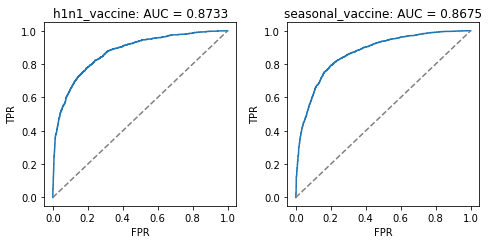

In [31]:
catboost_model = best_model_fit2(X_train, y_train, X_val, y_val,
                             CatBoostClassifier(), 
                             CatBoostClassifier_param)

In [71]:
set(train_df.columns)

{'age_group_35_to_44_years',
 'age_group_45_to_54_years',
 'age_group_55_to_64_years',
 'age_group_65_and_above_years',
 'behavioral_antiviral_meds_1',
 'behavioral_antiviral_meds_unknown',
 'behavioral_avoidance_1',
 'behavioral_avoidance_unknown',
 'behavioral_face_mask_1',
 'behavioral_face_mask_unknown',
 'behavioral_large_gatherings_1',
 'behavioral_large_gatherings_unknown',
 'behavioral_outside_home_1',
 'behavioral_outside_home_unknown',
 'behavioral_touch_face_1',
 'behavioral_touch_face_unknown',
 'behavioral_wash_hands_1',
 'behavioral_wash_hands_unknown',
 'census_msa_msa_principle_city',
 'census_msa_non_msa',
 'child_under_6_months_1',
 'child_under_6_months_unknown',
 'chronic_med_condition_1',
 'chronic_med_condition_unknown',
 'doctor_recc_h1n1_1',
 'doctor_recc_h1n1_unknown',
 'doctor_recc_seasonal_1',
 'doctor_recc_seasonal_unknown',
 'education_college_graduate',
 'education_less_than_12_years',
 'education_some_college',
 'education_unknown',
 'employment_industry_

In [ ]:
' - '  '_to_'
' '    '_'
'+'    '_and_above'
'.0'    ''
'-'     '_'
','     ''
'<'     'less_than'
'>'     'more_than' 


In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' - ','_to_').str.replace(' ','_').str.replace('+','_and_above').str.replace('.0','').str.replace('-','_').str.replace(',','').str.replace('<','less_than')..str.replace('>','more_than')


### Neural Networks

In [ ]:
# # mlp for multi-label classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_multilabel_classification
# from sklearn.model_selection import RepeatedKFold
# from keras.models import Sequential
# from keras.layers import Dense
# from sklearn.metrics import accuracy_score

In [ ]:
# def get_model(n_inputs, n_outputs):
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
# 	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
# 	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))    
# 	model.add(Dense(n_outputs, activation='sigmoid'))
# 	model.compile(loss='binary_crossentropy', optimizer='adam')
# 	return model

In [ ]:
# n_inputs, n_outputs = train_df.shape[1], train_labels.shape[1]
# model = get_model(n_inputs, n_outputs)

# # fit model
# model.fit(X_train, y_train, verbose=0, epochs=100)

# # make a prediction on the test set
# yhat = model.predict(X_val)
# # round probabilities to class labels
# yhat = yhat.round()
# # calculate accuracy
# acc = accuracy_score(y_val, yhat)
# acc

# Testing the models - for submission

In [ ]:
%%time

# Logit Model - using all train data including validation data

test_probas = full_logit_model.predict_proba(test_df)
test_probas

In [ ]:
%%time

# RF Model

test_probas = full_rf_model2.predict_proba(test_df)
test_probas


In [ ]:
%%time

# Extra Trees Model

test_probas = full_etc_model2.predict_proba(test_df)
test_probas

In [ ]:
%%time

# LightGB Model

test_probas = full_lgbm_model2.predict_proba(test_df)
test_probas

# Creating Submission File

In [ ]:
submission_df = pd.read_csv("submission_format.csv", 
                            index_col="respondent_id")

submission_df.head()

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

In [ ]:
# submission_df.to_csv('submission10_rf_new_v1.csv', index=True)

# submission_df.to_csv('submission8_logit_new_v1.csv', index=True)

# submission_df.to_csv('submission13_extratree.csv', index=True)

# submission_df.to_csv('submission15_lgbm_gridcv.csv', index=True)

# submission_df.to_csv('submission16_full_logit.csv', index=True)

# submission_df.to_csv('submission17_full_lgbm_model.csv', index=True)

# Feature Importance & MLI 

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Light GBM

In [218]:
def plot_imp_features(clf, data = train_df, n =10, title = 'Feature Importance'):

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, data.columns)), columns=['Value','Feature'])
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", 
                data=feature_imp.sort_values(by="Value", ascending=False)[:n], palette='flare_r')   # only top n features
    plt.title(title)
    plt.tight_layout()
    plt.show()
#     plt.savefig('lgbm_importances-01.png')

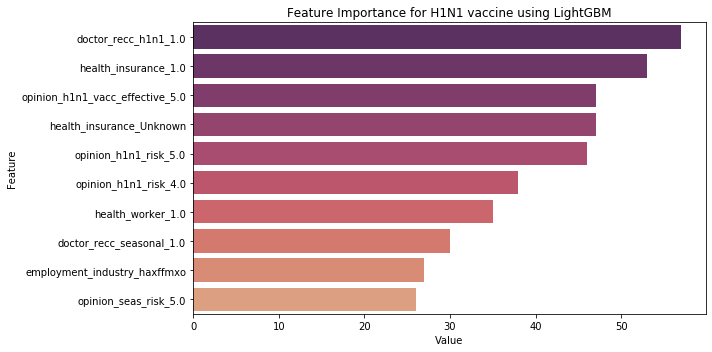

In [219]:
plot_imp_features(full_lgbm_model2.estimators_[0], n=10, title = 'Feature Importance for H1N1 vaccine using LightGBM')

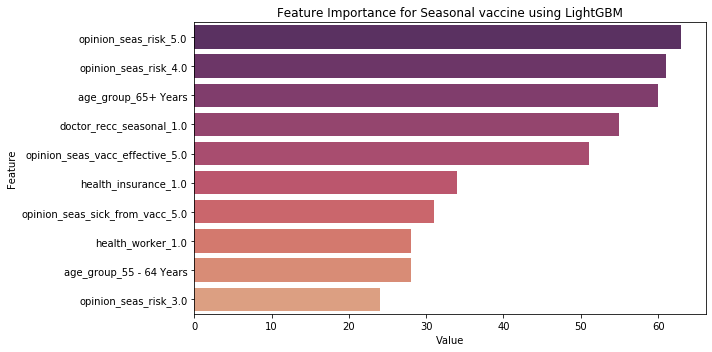

In [220]:
plot_imp_features(full_lgbm_model2.estimators_[1], title = 'Feature Importance for Seasonal vaccine using LightGBM')

### Logistic Regression

In [244]:
def plot_imp_features_reg(clf, data = train_df, n =10, threshold = 0.5, title = 'Feature Importance'):

    feature_imp = pd.DataFrame(sorted(zip(clf.coef_[0], data.columns)), 
                               columns=['Value','Feature'])
    
    # Finding top N important features
    feat_df = feature_imp[abs(feature_imp['Value']) > threshold] #.sort_values(by="Value", ascending=False)[:n]  # taking absolute value of the coefficient above the threshold
    
    df = feat_df.sort_values(by="Value", ascending=False)[:int(n/2)]
    df = df.append(feat_df.sort_values(by="Value", ascending=False)[-int(n/2):])

#     df = feature_imp[feature_imp['Value'] > threshold].sort_values(by="Value", ascending=False)[:n]
#     df = df.append(feature_imp[feature_imp['Value'] < -threshold].sort_values(by="Value", ascending=False)[-n:])


    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", 
                data=df, 
                palette='flare_r')
    plt.title(title)
    plt.tight_layout()
    plt.show()

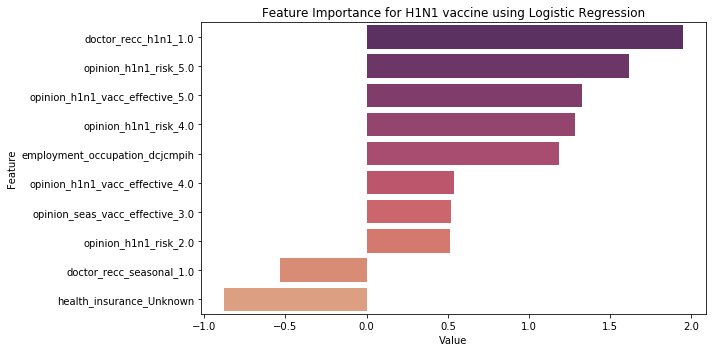

In [245]:
# filename = 'full_logit_model.sav'
# full_logit_model = pickle.load(open(filename, 'rb'))

plot_imp_features_reg(full_logit_model.estimators_[0], n=10, title = 'Feature Importance for H1N1 vaccine using Logistic Regression')

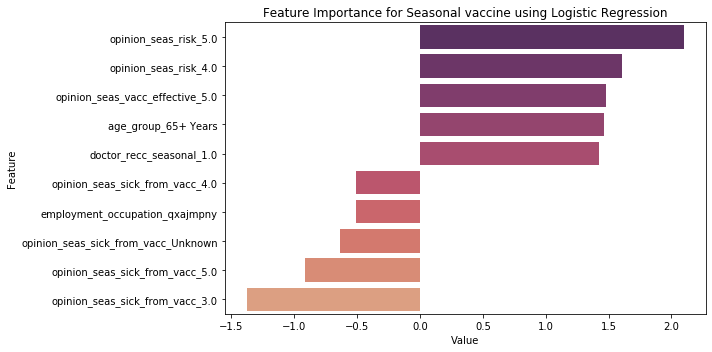

In [246]:
plot_imp_features_reg(full_logit_model.estimators_[1],n=10, title = 'Feature Importance for Seasonal vaccine using Logistic Regression')